# Combined HackerNews Score Prediction Model

This model combines:
1. Log transform target to fix skewing problem
2. Word count scaled as input (1D)
3. Time of day sin/cos features (2D)
4. Title embedding (200D)
5. **NEW**: Learnable domain embeddings
6. **NEW**: Learnable user embeddings


In [1]:
# Data Constants
NUMBER_OF_SAMPLES = 4000000
MINIMUM_SCORE = 7
MAXIMUM_SCORE = 1000
MIN_TRESHOLD = 10000
MAX_AUGMENT_PER_BIN = 10000
TOTAL_BUDGET = 80000 
NUM_DOMAINS = 200
NUM_USERS = 1000

# Model Architecture Constants
DOMAIN_EMB_DIM = 32        # Domain embedding dimension
USER_EMB_DIM = 64          # User embedding dimension  
TITLE_EMB_DIM = 200        # Title embedding dimension (from GloVe)
NUMERICAL_DIM = 5          # Number of numerical features (word_count, time_sin, time_cos, day_sin, day_cos)
HIDDEN_DIM = 256           # Hidden layer dimension
DROPOUT_RATE = 0.3         # Dropout rate

# Training Constants (you'll also want these for other cells)
BATCH_SIZE = 512           # Batch size for training
LEARNING_RATE = 0.01       # Learning rate
WEIGHT_DECAY = 1e-4        # Weight decay for AdamW
NUM_EPOCHS = 100           # Maximum training epochs
PATIENCE = 100             # Early stopping patience
FACTOR = 0.5               # Learning rate reduction factor
VAL_SIZE = 0.25            # Validation set size
TEST_SIZE = 0.2            # Test set size

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import requests
import zipfile
import os
import re
from io import BytesIO
from urllib.parse import urlparse

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_parquet('../data/hackernews_full_data.parquet')
print(f"Loaded {len(df):,} stories")

# Use a substantial sample for training
df_sample = df.sample(n=NUMBER_OF_SAMPLES, random_state=42).copy()
print(f"Using {len(df_sample):,} samples")


Using device: cpu
Loading data...
Loaded 4,902,536 stories
Using 4,000,000 samples


# Loading pre-trained GloVe embeddings

In [3]:
# Load GloVe embeddings for title embeddings
print("🔄 Loading pre-trained GloVe embeddings...")

glove_file = "../data/glove.6B.200d.txt"

if not os.path.exists(glove_file):
    print("Downloading GloVe 200d embeddings (this may take a moment)...")
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    
    response = requests.get(url, stream=True)
    with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
        with zip_file.open("glove.6B.200d.txt") as source:
            with open(glove_file, "wb") as target:
                target.write(source.read())
    print("✅ Download complete!")

# Load GloVe embeddings
print("Loading GloVe word vectors...")
word_to_index = {}
embeddings_list = []

with open(glove_file, 'r', encoding='utf-8') as f:
    for idx, line in enumerate(f):
        if idx % 50000 == 0:
            print(f"  Loaded {idx:,} words...")
        
        parts = line.strip().split()
        word = parts[0]
        vector = np.array([float(x) for x in parts[1:]])
        
        word_to_index[word] = len(embeddings_list)
        embeddings_list.append(vector)

embeddings = np.array(embeddings_list)

print(f"✅ GloVe embeddings loaded:")
print(f"  Vocabulary: {len(word_to_index):,} words")
print(f"  Embedding dim: {embeddings.shape[1]}")


🔄 Loading pre-trained GloVe embeddings...
Loading GloVe word vectors...
  Loaded 0 words...
  Loaded 50,000 words...
  Loaded 100,000 words...
  Loaded 150,000 words...
  Loaded 200,000 words...
  Loaded 250,000 words...
  Loaded 300,000 words...
  Loaded 350,000 words...
✅ GloVe embeddings loaded:
  Vocabulary: 400,000 words
  Embedding dim: 200


# Feature Engineering functions

In [7]:
# Feature engineering functions
def clean_text(text):
    """Clean text for embedding lookup"""
    text = text.lower()
    text = re.sub(r'-', ' ', text)  # Split hyphenated words
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.split()

def title_to_embedding(title, method='average'):
    """Convert title to embedding using GloVe"""
    words = clean_text(title)
    word_embeddings = []
    
    for word in words:
        if word in word_to_index:
            idx = word_to_index[word]
            word_embeddings.append(embeddings[idx])
    
    if word_embeddings:
        if method == 'average':
            return np.mean(word_embeddings, axis=0)
        elif method == 'sum':
            return np.sum(word_embeddings, axis=0)
        elif method == 'max':
            return np.max(word_embeddings, axis=0)
        else:
            return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(embeddings.shape[1])

def extract_domains(url):
    """Enhanced domain extraction with better cleansing"""
    if url is None or pd.isna(url) or url == '':
        return 'self_post'
    
    url = str(url).strip()
    if not url:
        return 'self_post'
    
    try:
        # Add protocol if missing
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url
        
        domain = urlparse(url).netloc.lower()
        
        # Remove common prefixes and suffixes
        prefixes = ['www.', 'm.', 'mobile.', 'old.']
        for prefix in prefixes:
            if domain.startswith(prefix):
                domain = domain[len(prefix):]
                break
        
        # Remove port numbers and trailing dots
        domain = domain.split(':')[0].rstrip('.')
        
        return domain if domain else 'parse_error'
        
    except:
        return 'parse_error'

def normalize_common_domains(domain):
    """Group related domains together"""
    domain_groups = {
        # Google ecosystem
        'youtube.com': 'google.com', 'youtu.be': 'google.com', 
        'blogspot.com': 'google.com', 'googleblog.blogspot.com': 'google.com',
        
        # Social media
        't.co': 'twitter.com', 'fb.me': 'facebook.com',
        
        # URL shorteners
        'bit.ly': 'url_shortener', 'tinyurl.com': 'url_shortener', 
        'goo.gl': 'url_shortener', 'ow.ly': 'url_shortener',
        
        # News variations
        'nyti.ms': 'nytimes.com',
        
        # GitHub
        'github.io': 'github.com',
        
        # Wikipedia
        'en.wikipedia.org': 'wikipedia.org'
    }
    
    return domain_groups.get(domain, domain)

print("✅ Feature engineering functions ready!")

✅ Feature engineering functions ready!


# CLEANSING DATASET

In [11]:
# Prepare the dataset with all features
print("Preparing comprehensive dataset...")

# Filter data: remove extreme outliers and missing values
df_filtered = df_sample[
    (df_sample['score'] >= MINIMUM_SCORE) &
    (df_sample['score'] <= MAXIMUM_SCORE) &
    (df_sample['title'].notna()) &
    (df_sample['by'].notna()) &
    (df_sample['time'].notna())
].copy()

print(f"Filtered to {len(df_filtered):,} samples")

# 1. Target: Simple log transform
df_filtered['score_log'] = np.log1p(df_filtered['score'])
df_filtered['score_final'] = df_filtered['score_log']

# 2. Title features: embeddings + word count
print("Processing title features...")
title_embeddings = []
word_counts = []

for i, title in enumerate(df_filtered['title']):
    if i % 10000 == 0:
        print(f"  Processing {i:,}/{len(df_filtered):,}...")
    
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    title_embeddings.append(emb)
    word_counts.append(word_count)

df_filtered['word_count'] = word_counts

# 3. Time features: cyclical encoding
print("Processing time features...")
df_filtered['timestamp'] = pd.to_datetime(df_filtered['time'])
df_filtered['hour_of_day'] = df_filtered['timestamp'].dt.hour

# Cyclical features for time of day
df_filtered['time_of_day_sin'] = np.sin(2 * np.pi * df_filtered['hour_of_day'] / 24)
df_filtered['time_of_day_cos'] = np.cos(2 * np.pi * df_filtered['hour_of_day'] / 24)

# Day of week features (cyclical encoding) - ADD THIS 
df_filtered['day_of_week'] = pd.to_datetime(df_filtered['time'], unit='s').dt.dayofweek  # 0=Monday, 6=Sunday
df_filtered['day_of_week_sin'] = np.sin(2 * np.pi * df_filtered['day_of_week'] / 7)
df_filtered['day_of_week_cos'] = np.cos(2 * np.pi * df_filtered['day_of_week'] / 7)


# 4. Domain processing with enhanced cleaning
print("Processing domain features...")
df_filtered['domain'] = df_filtered['url'].apply(extract_domains)
df_filtered['domain_normalized'] = df_filtered['domain'].apply(normalize_common_domains)
print("Sample domains:")
print(df_filtered['domain'].value_counts().head(10))

# 5. User processing for embeddings  
print("Processing user features...")
# Users are already in 'by' column

print("✅ Feature processing complete!")
print(f"Score range (original): {df_filtered['score'].min()} to {df_filtered['score'].max()}")
print(f"Score range (log): {df_filtered['score_log'].min():.3f} to {df_filtered['score_log'].max():.3f}")
print(f"Unique domains: {df_filtered['domain'].nunique():,}")
print(f"Unique normalized domains: {df_filtered['domain_normalized'].nunique():,}")
print(f"Unique users: {df_filtered['by'].nunique():,}")
print(f"Day of week features added:")
print(f"  Monday=0, Sunday=6")
print(f"  Sample values: {df_filtered[['day_of_week', 'day_of_week_sin', 'day_of_week_cos']].head()}")

Preparing comprehensive dataset...
Filtered to 669,341 samples
Processing title features...
  Processing 0/669,341...
  Processing 10,000/669,341...
  Processing 20,000/669,341...
  Processing 30,000/669,341...
  Processing 40,000/669,341...
  Processing 50,000/669,341...
  Processing 60,000/669,341...
  Processing 70,000/669,341...
  Processing 80,000/669,341...
  Processing 90,000/669,341...
  Processing 100,000/669,341...
  Processing 110,000/669,341...
  Processing 120,000/669,341...
  Processing 130,000/669,341...
  Processing 140,000/669,341...
  Processing 150,000/669,341...
  Processing 160,000/669,341...
  Processing 170,000/669,341...
  Processing 180,000/669,341...
  Processing 190,000/669,341...
  Processing 200,000/669,341...
  Processing 210,000/669,341...
  Processing 220,000/669,341...
  Processing 230,000/669,341...
  Processing 240,000/669,341...
  Processing 250,000/669,341...
  Processing 260,000/669,341...
  Processing 270,000/669,341...
  Processing 280,000/669,34

# Analyze distribution

🔄 Analyzing current score distribution...


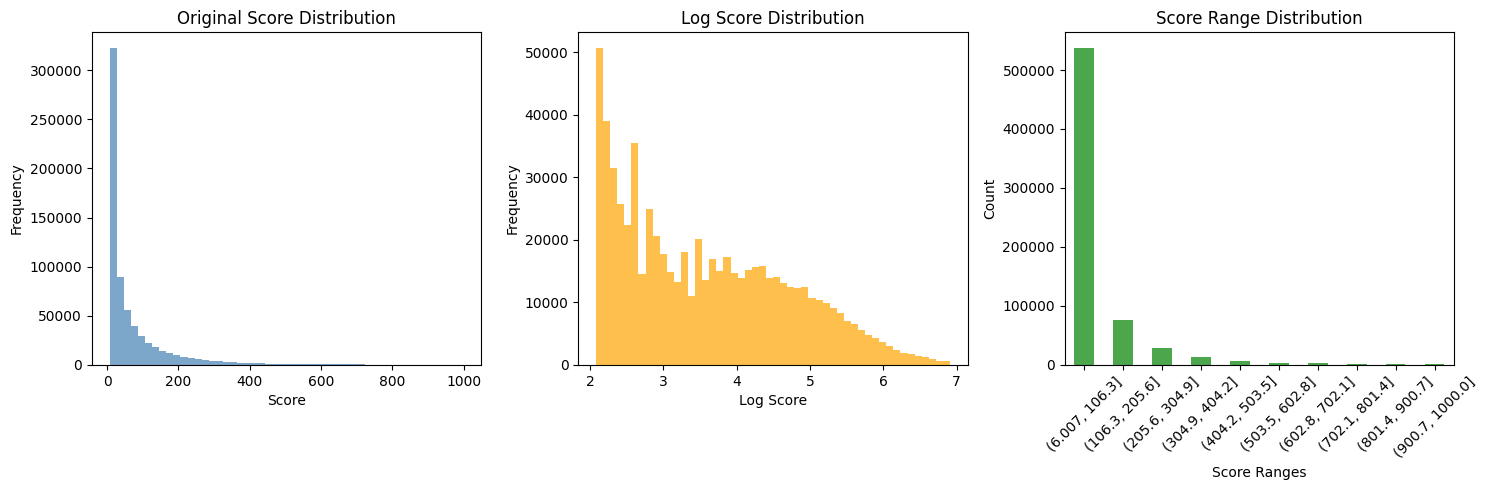

Score statistics:
  Min: 7
  Max: 1000
  Mean: 71.1
  Median: 29.0
  Std: 107.4

Score range counts:
  (6.007, 106.3]: 537,073 samples
  (106.3, 205.6]: 75,479 samples
  (205.6, 304.9]: 28,743 samples
  (304.9, 404.2]: 13,084 samples
  (404.2, 503.5]: 6,491 samples
  (503.5, 602.8]: 3,471 samples
  (602.8, 702.1]: 2,300 samples
  (702.1, 801.4]: 1,336 samples
  (801.4, 900.7]: 787 samples
  (900.7, 1000.0]: 577 samples


In [12]:
# Data Augmentation for Uniform Distribution
print("🔄 Analyzing current score distribution...")

# Check current distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_filtered['score'], bins=50, alpha=0.7, color='steelblue')
plt.title('Original Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_filtered['score_final'], bins=50, alpha=0.7, color='orange')
plt.title('Log Score Distribution')
plt.xlabel('Log Score')
plt.ylabel('Frequency')

# Show score ranges
score_ranges = pd.cut(df_filtered['score'], bins=10)
range_counts = score_ranges.value_counts().sort_index()
plt.subplot(1, 3, 3)
range_counts.plot(kind='bar', color='green', alpha=0.7)
plt.title('Score Range Distribution')
plt.xlabel('Score Ranges')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"Score statistics:")
print(f"  Min: {df_filtered['score'].min()}")
print(f"  Max: {df_filtered['score'].max()}")
print(f"  Mean: {df_filtered['score'].mean():.1f}")
print(f"  Median: {df_filtered['score'].median():.1f}")
print(f"  Std: {df_filtered['score'].std():.1f}")

print("\nScore range counts:")
for interval, count in range_counts.items():
    print(f"  {interval}: {count:,} samples")


In [14]:
# Simple Data Augmentation - Focus on HIGH log scores
print("🚀 Simple augmentation strategy for high-scoring posts...")

# Simple text augmentation - no external libraries needed
def simple_text_augment(title):
    """Simple text variations using basic substitutions"""
    # Common tech synonyms for HackerNews titles
    simple_synonyms = {
        'new': ['latest', 'fresh', 'recent'],
        'best': ['top', 'great', 'excellent'], 
        'simple': ['easy', 'basic', 'minimal'],
        'fast': ['quick', 'rapid', 'speedy'],
        'build': ['create', 'make', 'develop'],
        'use': ['utilize', 'leverage', 'employ'],
        'good': ['great', 'solid', 'effective'],
        'free': ['open', 'gratis'],
        'guide': ['tutorial', 'howto'],
        'tool': ['utility', 'app', 'software'],
        'way': ['method', 'approach'],
        'learn': ['master', 'understand'],
        'python': ['Python'],  # capitalize
        'javascript': ['JavaScript'],  # capitalize
    }
    
    words = title.split()
    # Only replace 1 word randomly
    if len(words) > 2 and np.random.random() < 0.5:
        for i, word in enumerate(words):
            if word.lower() in simple_synonyms and np.random.random() < 0.3:
                words[i] = np.random.choice(simple_synonyms[word.lower()])
                break  # Only replace one word
    
    return ' '.join(words)

print("🚀 Simple augmentation for high-scoring posts...")

# Simple strategy: 
# - For high log scores (rare), add more samples  
# - For low log scores (common), add none
# - Use basic synonym replacement
# - Keep other features mostly unchanged

print("Analyzing log score distribution...")
log_scores = df_filtered['score_log'].values
log_score_bins = np.linspace(log_scores.min(), log_scores.max(), 20)  # 20 bins
df_filtered['log_bin'] = pd.cut(df_filtered['score_log'], bins=log_score_bins, include_lowest=True)

# Count samples per bin
bin_counts = df_filtered['log_bin'].value_counts().sort_index()
print("\nCurrent distribution (log score bins):")
for bin_label, count in bin_counts.items():
    print(f"  {bin_label}: {count:,} samples")

# Simple rule: only augment bins with < 10000 samples (the high score bins)
min_threshold = MIN_TRESHOLD
max_augment_per_bin = MAX_AUGMENT_PER_BIN  # Don't go crazy
total_budget = TOTAL_BUDGET  # Max 50k new samples (~9% of original)

print(f"\nAugmentation plan:")
print(f"- Only augment bins with < {min_threshold:,} samples")
print(f"- Max {max_augment_per_bin:,} new samples per bin")  
print(f"- Total budget: {total_budget:,} samples")
print("- Using simple synonym replacement (no external libraries)")

# Process bins and create augmented data
augmented_data = [df_filtered]  # Start with original data
total_added = 0
np.random.seed(42)

for bin_label, current_count in bin_counts.items():
    if current_count >= min_threshold:
        continue  # Skip - already have enough samples
    
    if total_added >= total_budget:
        print(f"Reached budget limit of {total_budget:,} samples")
        break
    
    # How many to add for this bin
    needed = min(min_threshold - current_count, max_augment_per_bin)
    needed = min(needed, total_budget - total_added)  # Don't exceed budget
    
    if needed <= 0:
        continue
    
    print(f"Bin {bin_label}: {current_count} -> {current_count + needed} (+{needed})")
    
    # Get samples from this bin
    bin_data = df_filtered[df_filtered['log_bin'] == bin_label]
    
    # Create augmented samples
    augmented_rows = []
    for _ in range(needed):
        # Pick a random sample from this bin
        base_row = bin_data.sample(1).iloc[0].copy()
        
        # Simple text augmentation 
        base_row['title'] = simple_text_augment(base_row['title'])
        
        # Tiny noise to time features (simulate different posting times)
        hour_noise = np.random.normal(0, 0.5)  # ±30 min variation
        new_hour = (base_row['hour_of_day'] + hour_noise) % 24
        base_row['hour_of_day'] = new_hour
        base_row['time_of_day_sin'] = np.sin(2 * np.pi * new_hour / 24)
        base_row['time_of_day_cos'] = np.cos(2 * np.pi * new_hour / 24)

        # Add day of week features
        base_row['day_of_week'] = pd.to_datetime(base_row['time'], unit='s').dayofweek
        base_row['day_of_week_sin'] = np.sin(2 * np.pi * base_row['day_of_week'] / 7)
        base_row['day_of_week_cos'] = np.cos(2 * np.pi * base_row['day_of_week'] / 7)

        
        # Recalculate word count (might have changed due to augmentation)
        base_row['word_count'] = len(base_row['title'].strip().split())
        
        augmented_rows.append(base_row)
    
    # Add to augmented data
    if augmented_rows:
        augmented_df = pd.DataFrame(augmented_rows)
        augmented_data.append(augmented_df)
        total_added += len(augmented_rows)

# Combine all data
print("\nCombining data...")
df_augmented = pd.concat(augmented_data, ignore_index=True)
df_augmented = df_augmented.drop('log_bin', axis=1)

print(f"✅ Simple augmentation complete!")
print(f"Original: {len(df_filtered):,} samples")
print(f"Final: {len(df_augmented):,} samples")
print(f"Added: {total_added:,} samples ({total_added/len(df_filtered)*100:.1f}% increase)")

# Quick check: verify we helped high-score distribution
print(f"\nDistribution check:")
print(f"Before - High scores (log>6): {(df_filtered['score_log'] > 6).sum():,}")
print(f"After - High scores (log>6): {(df_augmented['score_log'] > 6).sum():,}")


🚀 Simple augmentation strategy for high-scoring posts...
🚀 Simple augmentation for high-scoring posts...
Analyzing log score distribution...

Current distribution (log score bins):
  (2.0780000000000003, 2.334]: 120,999 samples
  (2.334, 2.588]: 66,965 samples
  (2.588, 2.842]: 56,010 samples
  (2.842, 3.096]: 45,994 samples
  (3.096, 3.35]: 38,542 samples
  (3.35, 3.604]: 40,189 samples
  (3.604, 3.859]: 43,458 samples
  (3.859, 4.113]: 41,356 samples
  (4.113, 4.367]: 38,153 samples
  (4.367, 4.621]: 37,747 samples
  (4.621, 4.875]: 33,725 samples
  (4.875, 5.13]: 29,110 samples
  (5.13, 5.384]: 24,855 samples
  (5.384, 5.638]: 19,056 samples
  (5.638, 5.892]: 13,761 samples
  (5.892, 6.146]: 8,942 samples
  (6.146, 6.4]: 5,452 samples
  (6.4, 6.655]: 3,375 samples
  (6.655, 6.909]: 1,652 samples

Augmentation plan:
- Only augment bins with < 10,000 samples
- Max 10,000 new samples per bin
- Total budget: 80,000 samples
- Using simple synonym replacement (no external libraries)
Bin (

📊 Augmentation Results:


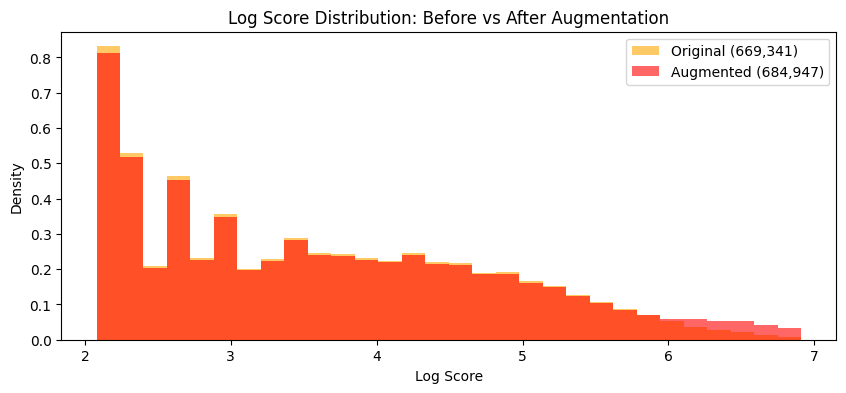


✅ Summary:
  Original samples: 669,341
  Final samples: 684,947
  Added: 15,606 samples (2.3% increase)
  Uniformity improvement: +6.3%
  High scores (log>6): 15,145 → 30,261 (2.0x more)


In [26]:
# Quick check of augmentation results
print("📊 Augmentation Results:")

# Simple comparison plot
plt.figure(figsize=(10, 4))
plt.hist(df_filtered['score_log'], bins=30, alpha=0.6, color='orange', 
         label=f'Original ({len(df_filtered):,})', density=True)
plt.hist(df_augmented['score_log'], bins=30, alpha=0.6, color='red', 
         label=f'Augmented ({len(df_augmented):,})', density=True)
plt.title('Log Score Distribution: Before vs After Augmentation')
plt.xlabel('Log Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Key statistics
print(f"\n✅ Summary:")
print(f"  Original samples: {len(df_filtered):,}")
print(f"  Final samples: {len(df_augmented):,}")
print(f"  Added: {len(df_augmented) - len(df_filtered):,} samples ({(len(df_augmented) - len(df_filtered))/len(df_filtered)*100:.1f}% increase)")

# Check uniformity improvement
log_ranges_orig = pd.cut(df_filtered['score_log'], bins=10).value_counts()
log_ranges_aug = pd.cut(df_augmented['score_log'], bins=10).value_counts()
orig_cv = log_ranges_orig.std() / log_ranges_orig.mean()
aug_cv = log_ranges_aug.std() / log_ranges_aug.mean()
print(f"  Uniformity improvement: {((orig_cv - aug_cv) / orig_cv * 100):+.1f}%")

# High score check
high_scores_orig = (df_filtered['score_log'] > 6).sum()
high_scores_aug = (df_augmented['score_log'] > 6).sum()
print(f"  High scores (log>6): {high_scores_orig:,} → {high_scores_aug:,} ({high_scores_aug/high_scores_orig:.1f}x more)")

In [27]:
# Update the rest of the pipeline to use augmented data
print("🔄 Updating feature processing for augmented dataset...")

# Replace df_filtered with df_augmented for the rest of the pipeline
df_filtered = df_augmented.copy()

# Reprocess title embeddings for new/modified titles
print("Reprocessing title features for augmented data...")
title_embeddings = []
word_counts = []

for i, title in enumerate(df_filtered['title']):
    if i % 20000 == 0:
        print(f"  Processing {i:,}/{len(df_filtered):,}...")
    
    emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    title_embeddings.append(emb)
    word_counts.append(word_count)

df_filtered['word_count'] = word_counts

print("✅ Feature processing updated for augmented dataset!")
print(f"New dataset size: {len(df_filtered):,} samples")

# Show some examples of augmented titles
print(f"\n📝 Sample augmented titles:")
sample_titles = df_filtered['title'].sample(10, random_state=42)
for i, title in enumerate(sample_titles, 1):
    print(f"  {i:2d}. {title}")

# Verify score distribution coverage
print(f"\n📊 Score coverage verification:")
print(f"Score range: {df_filtered['score'].min():.1f} - {df_filtered['score'].max():.1f}")
print(f"Unique scores: {df_filtered['score'].nunique():,}")

# Show distribution across different score ranges
score_ranges = [(10, 50), (50, 100), (100, 200), (200, 500), (500, 1000)]
for low, high in score_ranges:
    count = len(df_filtered[(df_filtered['score'] >= low) & (df_filtered['score'] < high)])
    pct = count / len(df_filtered) * 100
    print(f"  {low:3d}-{high:3d}: {count:6,} samples ({pct:4.1f}%)")


🔄 Updating feature processing for augmented dataset...
Reprocessing title features for augmented data...
  Processing 0/684,947...
  Processing 20,000/684,947...
  Processing 40,000/684,947...
  Processing 60,000/684,947...
  Processing 80,000/684,947...
  Processing 100,000/684,947...
  Processing 120,000/684,947...
  Processing 140,000/684,947...
  Processing 160,000/684,947...
  Processing 180,000/684,947...
  Processing 200,000/684,947...
  Processing 220,000/684,947...
  Processing 240,000/684,947...
  Processing 260,000/684,947...
  Processing 280,000/684,947...
  Processing 300,000/684,947...
  Processing 320,000/684,947...
  Processing 340,000/684,947...
  Processing 360,000/684,947...
  Processing 380,000/684,947...
  Processing 400,000/684,947...
  Processing 420,000/684,947...
  Processing 440,000/684,947...
  Processing 460,000/684,947...
  Processing 480,000/684,947...
  Processing 500,000/684,947...
  Processing 520,000/684,947...
  Processing 540,000/684,947...
  Process

In [ ]:
# Prepare embeddings vocabulary
print("Preparing embedding vocabularies...")

# Domain vocabulary: Keep top domains, group others as 'OTHER'
domain_counts = df_filtered['domain'].value_counts()
top_domains = domain_counts.head(NUM_DOMAINS).index.tolist()  # Keep top 1000 domains
df_filtered['domain_mapped'] = df_filtered['domain'].apply(
    lambda x: x if x in top_domains else 'OTHER'
)

# User vocabulary: Keep top users, group others as 'OTHER'
user_counts = df_filtered['by'].value_counts()
top_users = user_counts.head(NUM_USERS).index.tolist()  # Keep top 5000 users
df_filtered['user_mapped'] = df_filtered['by'].apply(
    lambda x: x if x in top_users else 'OTHER'
)

# Create label encoders
domain_encoder = LabelEncoder()
user_encoder = LabelEncoder()

domain_ids = domain_encoder.fit_transform(df_filtered['domain_mapped'])
user_ids = user_encoder.fit_transform(df_filtered['user_mapped'])

print(f"Domain vocabulary size: {len(domain_encoder.classes_)}")
print(f"User vocabulary size: {len(user_encoder.classes_)}")

# Store encoders for later use
n_domains = len(domain_encoder.classes_)
n_users = len(user_encoder.classes_)

print("✅ Embedding vocabularies ready!")


Preparing embedding vocabularies...
Domain vocabulary size: 201
User vocabulary size: 1001
✅ Embedding vocabularies ready!


In [ ]:
# Prepare final feature matrices
print("Preparing final feature matrices...")

# Features for the neural network:
# 1. Title embeddings (200D)
X_title_embeddings = np.array(title_embeddings)

# 2. Numerical features (scaled): word_count, time_sin, time_cos, day_sin, day_cos
numerical_features = np.column_stack([
    df_filtered['word_count'].values,
    df_filtered['time_of_day_sin'].values,
    df_filtered['time_of_day_cos'].values,
    df_filtered['day_of_week_sin'].values,
    df_filtered['day_of_week_cos'].values
])

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(numerical_features)

# 3. IDs for embeddings
X_domain_ids = domain_ids
X_user_ids = user_ids

# 4. Target - Using normal log transform (log1p)
y = df_filtered['score_log'].values  # Using normal log transform (log1p)
y_original = df_filtered['score'].values  # Keep for evaluation

print(f"Target variable comparison (first 10 samples):")
print(f"Original scores:    {y_original[:10]}")
print(f"Log transform:      {y[:10]}")
print(f"\\nUsing standard log1p transform for target variable!")

print(f"Feature shapes:")
print(f"  Title embeddings: {X_title_embeddings.shape}")
print(f"  Numerical features: {X_numerical_scaled.shape}")
print(f"  Domain IDs: {X_domain_ids.shape}")
print(f"  User IDs: {X_user_ids.shape}")
print(f"  Target: {y.shape}")

# Train/validation/test split
# First split: train+val vs test
indices = np.arange(len(y))
train_val_idx, test_idx = train_test_split(indices, test_size=VAL_SIZE, random_state=42)

# Second split: train vs val
train_idx, val_idx = train_test_split(train_val_idx, test_size=TEST_SIZE, random_state=42)  # 0.25 * 0.8 = 0.2

print(f"Split sizes: Train={len(train_idx):,}, Val={len(val_idx):,}, Test={len(test_idx):,}")

print("✅ Feature matrices ready!")


Preparing final feature matrices...
Target variable comparison (first 10 samples):
Original scores:    [  7  25   9  19  48 160  44  49  20  30]
Log transform:      [2.07944154 3.25809654 2.30258509 2.99573227 3.8918203  5.08140436
 3.80666249 3.91202301 3.04452244 3.4339872 ]
Aggressive transform: [2.07944154 3.25809654 2.30258509 2.99573227 3.8918203  5.08140436
 3.80666249 3.91202301 3.04452244 3.4339872 ]
\nAggressive transform provides better low-score discrimination!
Feature shapes:
  Title embeddings: (684947, 200)
  Numerical features: (684947, 3)
  Domain IDs: (684947,)
  User IDs: (684947,)
  Target: (684947,)
Split sizes: Train=410,967, Val=136,990, Test=136,990
✅ Feature matrices ready!


In [ ]:
# Define the combined model architecture
class CombinedScorePredictor(nn.Module):
    def __init__(self, n_domains, n_users, domain_emb_dim=32, user_emb_dim=64, 
                 title_emb_dim=200, numerical_dim=3, hidden_dim=256, dropout=0.3):
        super(CombinedScorePredictor, self).__init__()
        
        # Learnable embeddings
        self.domain_embedding = nn.Embedding(n_domains, domain_emb_dim)
        self.user_embedding = nn.Embedding(n_users, user_emb_dim)
        
        # Calculate total input dimension
        total_input_dim = title_emb_dim + numerical_dim + domain_emb_dim + user_emb_dim
        
        # Main neural network
        self.model = nn.Sequential(
            nn.Linear(total_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, 1)
        )
        
    def forward(self, title_emb, numerical_features, domain_ids, user_ids):
        # Get embeddings
        domain_emb = self.domain_embedding(domain_ids)
        user_emb = self.user_embedding(user_ids)
        
        # Concatenate all features
        combined = torch.cat([
            title_emb,
            numerical_features,
            domain_emb,
            user_emb
        ], dim=1)
        
        # Forward pass
        return self.model(combined).squeeze(1)

# Initialize model
model = CombinedScorePredictor(
    n_domains=n_domains,
    n_users=n_users,
    domain_emb_dim=DOMAIN_EMB_DIM,
    user_emb_dim=USER_EMB_DIM,
    title_emb_dim=TITLE_EMB_DIM,
    numerical_dim=NUMERICAL_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT_RATE
).to(device)

print(f"Model architecture:")
print(f"  Domain embedding: {n_domains} -> {DOMAIN_EMB_DIM}")
print(f"  User embedding: {n_users} -> {USER_EMB_DIM}")
print(f"  Total input dim: {TITLE_EMB_DIM + NUMERICAL_DIM + DOMAIN_EMB_DIM + USER_EMB_DIM} = {TITLE_EMB_DIM + NUMERICAL_DIM + DOMAIN_EMB_DIM + USER_EMB_DIM}")
print(f"  Hidden layers: {TITLE_EMB_DIM + NUMERICAL_DIM + DOMAIN_EMB_DIM + USER_EMB_DIM} -> {HIDDEN_DIM} -> {HIDDEN_DIM // 2} -> {HIDDEN_DIM // 4} -> 1")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print("✅ Combined model ready!")


Model architecture:
  Domain embedding: 201 -> 32
  User embedding: 1001 -> 64
  Total input dim: 299 = 299
  Hidden layers: 299 -> 256 -> 128 -> 64 -> 1
  Total parameters: 188,513
✅ Combined model ready!


In [31]:
# Training setup
def create_data_loader(indices, batch_size=512, shuffle=True):
    """Create data loader for given indices"""
    title_emb_batch = torch.FloatTensor(X_title_embeddings[indices]).to(device)
    numerical_batch = torch.FloatTensor(X_numerical_scaled[indices]).to(device)
    domain_batch = torch.LongTensor(X_domain_ids[indices]).to(device)
    user_batch = torch.LongTensor(X_user_ids[indices]).to(device)
    target_batch = torch.FloatTensor(y[indices]).to(device)
    
    dataset = TensorDataset(title_emb_batch, numerical_batch, domain_batch, user_batch, target_batch)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create data loaders
train_loader = create_data_loader(train_idx, batch_size=BATCH_SIZE, shuffle=True)
val_loader = create_data_loader(val_idx, batch_size=BATCH_SIZE, shuffle=False)
test_loader = create_data_loader(test_idx, batch_size=BATCH_SIZE, shuffle=False)

# Training configuration
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=FACTOR)

print(f"Training setup:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")

print("✅ Training setup complete!")


Training setup:
  Train batches: 803
  Val batches: 268
  Test batches: 268
  Optimizer: AdamW (lr=0.01, weight_decay=1e-4)
✅ Training setup complete!


In [32]:
# Training loop
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for title_emb, numerical, domain_ids, user_ids, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(title_emb, numerical, domain_ids, user_ids)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for title_emb, numerical, domain_ids, user_ids, targets in data_loader:
            outputs = model(title_emb, numerical, domain_ids, user_ids)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    
    # Calculate R² on original scale
    predictions_orig = np.expm1(all_predictions)
    targets_orig = np.expm1(all_targets)
    r2 = r2_score(targets_orig, predictions_orig)
    rmse = np.sqrt(mean_squared_error(targets_orig, predictions_orig))
    r2_log = r2_score(np.log1p(targets_orig), np.log1p(predictions_orig))
    
    return avg_loss, r2, rmse, r2_log

print("✅ Training functions ready!")


✅ Training functions ready!


In [33]:
# Main training loop
print("🚀 Starting training...")

num_epochs = NUM_EPOCHS
best_val_r2 = -float('inf')
patience_counter = 0
max_patience = PATIENCE

# Training history
train_losses = []
val_losses = []
val_r2_scores = []
val_rmse_scores = []
val_r2_log_scores = []

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Validation
    val_loss, val_r2, val_rmse, val_r2_log = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)
    val_rmse_scores.append(val_rmse)
    val_r2_log_scores.append(val_r2_log)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Early stopping
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_combined_model.pth')
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1:2d}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, "
          f"Val Loss={val_loss:.4f}, "
          f"Val R²={val_r2:.4f}, "
          f"Val RMSE={val_rmse:.1f}",
          f"Val R² (log scale): {val_r2_log:.4f}")
    
    if patience_counter >= max_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\n✅ Training complete!")
print(f"Best validation R²: {best_val_r2:.4f}")


🚀 Starting training...
Epoch  1/100: Train Loss=2.1137, Val Loss=1.5654, Val R²=-0.1649, Val RMSE=153.2 Val R² (log scale): -0.0482
Epoch  2/100: Train Loss=1.4132, Val Loss=1.4823, Val R²=-0.1466, Val RMSE=152.0 Val R² (log scale): 0.0074
Epoch  3/100: Train Loss=1.3820, Val Loss=1.3761, Val R²=-0.0882, Val RMSE=148.1 Val R² (log scale): 0.0785
Epoch  4/100: Train Loss=1.3731, Val Loss=1.3741, Val R²=-0.0846, Val RMSE=147.8 Val R² (log scale): 0.0798
Epoch  5/100: Train Loss=1.3680, Val Loss=1.3816, Val R²=-0.0998, Val RMSE=148.9 Val R² (log scale): 0.0748
Epoch  6/100: Train Loss=1.3627, Val Loss=1.3754, Val R²=-0.0864, Val RMSE=148.0 Val R² (log scale): 0.0789
Epoch  7/100: Train Loss=1.3589, Val Loss=1.3652, Val R²=-0.0842, Val RMSE=147.8 Val R² (log scale): 0.0858
Epoch  8/100: Train Loss=1.3541, Val Loss=1.3574, Val R²=-0.0726, Val RMSE=147.0 Val R² (log scale): 0.0910
Epoch  9/100: Train Loss=1.3522, Val Loss=1.3604, Val R²=-0.0698, Val RMSE=146.8 Val R² (log scale): 0.0890
Epoc

: 

In [ ]:
# Load best model and evaluate on test set
print("📊 Final evaluation on test set...")

# Load best model
model.load_state_dict(torch.load('best_combined_model.pth'))

# Test evaluation
test_loss, test_r2, test_rmse, test_r2_log = evaluate_model(model, test_loader, criterion)

print(f"\n🎯 FINAL RESULTS:")
print(f"  Test Loss (log scale): {test_loss:.4f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test RMSE: {test_rmse:.1f} points")
print(f"  Test R² (log scale): {test_r2_log:.4f}")

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.yscale('log')

plt.subplot(1, 3, 2)
plt.plot(val_r2_scores)
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Score')

plt.subplot(1, 3, 3)
plt.plot(val_rmse_scores)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE')

plt.tight_layout()
plt.show()

print("✅ Evaluation complete!")


In [ ]:
# Prediction function for new stories
def predict_story_score(title, domain, user, hour_of_day=12, day_of_week=1):
    """Predict score for a new story
    
    Args:
        title: Story title
        domain: Domain name  
        user: Username
        hour_of_day: Hour (0-23), default=12 (noon)
        day_of_week: Day of week (0=Monday, 6=Sunday), default=1 (Tuesday)
    """
    model.eval()
    
    # Process title
    title_emb = title_to_embedding(title)
    word_count = len(title.strip().split())
    
    # Time features
    time_sin = np.sin(2 * np.pi * hour_of_day / 24)
    time_cos = np.cos(2 * np.pi * hour_of_day / 24)
    
    # Day of week features
    day_sin = np.sin(2 * np.pi * day_of_week / 7)
    day_cos = np.cos(2 * np.pi * day_of_week / 7)
    
    # Map domain and user
    domain_mapped = domain if domain in domain_encoder.classes_ else 'OTHER'
    user_mapped = user if user in user_encoder.classes_ else 'OTHER'
    
    try:
        domain_id = domain_encoder.transform([domain_mapped])[0]
        user_id = user_encoder.transform([user_mapped])[0]
    except:
        # Fallback to 'OTHER'
        domain_id = domain_encoder.transform(['OTHER'])[0]
        user_id = user_encoder.transform(['OTHER'])[0]
    
    # Create tensors (now with 5 numerical features)
    title_tensor = torch.FloatTensor(title_emb).unsqueeze(0).to(device)
    numerical_tensor = torch.FloatTensor(scaler.transform([[word_count, time_sin, time_cos, day_sin, day_cos]])).to(device)
    domain_tensor = torch.LongTensor([domain_id]).to(device)
    user_tensor = torch.LongTensor([user_id]).to(device)
    
    # Predict
    with torch.no_grad():
        pred_log = model(title_tensor, numerical_tensor, domain_tensor, user_tensor)
        pred_orig = np.expm1(pred_log.cpu().item())
    
    return max(1, int(pred_orig))  # Ensure positive integer

# Test predictions on REAL data from test set
print("🧪 Testing predictions on REAL examples from test set:")
print("=" * 70)

# Sample some interesting examples from test set
np.random.seed(42)  # For reproducible results
n_test_examples = 10

# Get test data
test_indices = test_idx
test_sample_indices = np.random.choice(test_indices, n_test_examples, replace=False)

# Create comparison
predictions_vs_actual = []

for i, idx in enumerate(test_sample_indices):
    # Get actual data
    row = df_filtered.iloc[idx]
    actual_score = int(row['score'])
    title = row['title']
    domain = row['domain']
    user = row['by']
    hour = row['hour_of_day']
    day = row['day_of_week']
    
    # Get prediction
    predicted_score = predict_story_score(title, domain, user, hour, day)
    
    # Store for analysis
    predictions_vs_actual.append({
        'title': title,
        'actual': actual_score,
        'predicted': predicted_score,
        'domain': domain,
        'user': user,
        'hour': hour,
        'day': day
    })
    
    # Calculate error
    error = abs(predicted_score - actual_score)
    error_pct = (error / actual_score) * 100 if actual_score > 0 else 0
    
    print(f"\n{i+1:2d}. Title: '{title[:60]}{'...' if len(title) > 60 else ''}'")
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    day_name = day_names[int(day)] if 0 <= day <= 6 else f"Day{day}"
    print(f"    Domain: {domain}, User: {user}, Hour: {hour:.1f}, Day: {day_name}")
    print(f"    Actual: {actual_score:4d} | Predicted: {predicted_score:4d} | Error: ±{error:4d} ({error_pct:.1f}%)")

# Calculate summary statistics
df_comparison = pd.DataFrame(predictions_vs_actual)

print(f"\n📊 PREDICTION ACCURACY SUMMARY:")
print("=" * 50)

# Basic error metrics
mae = np.mean(np.abs(df_comparison['predicted'] - df_comparison['actual']))
rmse = np.sqrt(np.mean((df_comparison['predicted'] - df_comparison['actual'])**2))
mape = np.mean(np.abs((df_comparison['predicted'] - df_comparison['actual']) / df_comparison['actual'])) * 100

print(f"Mean Absolute Error (MAE):     {mae:.1f} points")
print(f"Root Mean Square Error (RMSE): {rmse:.1f} points")
print(f"Mean Absolute Percentage Error: {mape:.1f}%")

# Correlation between predicted and actual
correlation = np.corrcoef(df_comparison['predicted'], df_comparison['actual'])[0,1]
print(f"Prediction Correlation:        {correlation:.3f}")

# Check how often we get the "direction" right (high vs low scores)
median_actual = df_comparison['actual'].median()
actual_high = df_comparison['actual'] > median_actual
predicted_high = df_comparison['predicted'] > median_actual
direction_accuracy = (actual_high == predicted_high).mean() * 100

print(f"Direction Accuracy (high/low): {direction_accuracy:.1f}%")

# Score range analysis
print(f"\n🎯 SCORE RANGE BREAKDOWN:")
print("=" * 30)

score_ranges = [(10, 50), (50, 100), (100, 200), (200, 500), (500, 1000)]
for low, high in score_ranges:
    range_mask = (df_comparison['actual'] >= low) & (df_comparison['actual'] < high)
    if range_mask.any():
        range_data = df_comparison[range_mask]
        range_mae = np.mean(np.abs(range_data['predicted'] - range_data['actual']))
        print(f"  {low:3d}-{high:3d} points: {len(range_data)} samples, MAE = {range_mae:.1f}")

print(f"\n💡 INSIGHTS:")
print("=" * 15)
if mape < 50:
    print("✅ Model predictions are reasonably accurate!")
elif mape < 100:
    print("🟡 Model shows some predictive ability, but with high variance")
else:
    print("❌ Model predictions are quite uncertain")

if correlation > 0.3:
    print("✅ Strong correlation between predicted and actual scores!")
elif correlation > 0.1:
    print("🟡 Moderate correlation - model captures some patterns")
else:
    print("❌ Weak correlation - model may be overfitting or missing key signals")

if direction_accuracy > 70:
    print("✅ Good at identifying high vs low scoring content!")
elif direction_accuracy > 60:
    print("🟡 Decent at ranking relative content quality")
else:
    print("❌ Struggles to rank content effectively")

# Optional: Plot predictions vs actual
try:
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(df_comparison['actual'], df_comparison['predicted'], alpha=0.7)
    plt.plot([df_comparison['actual'].min(), df_comparison['actual'].max()], 
             [df_comparison['actual'].min(), df_comparison['actual'].max()], 
             'r--', label='Perfect prediction')
    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    plt.title(f'Predicted vs Actual\n(R = {correlation:.3f})')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    errors = df_comparison['predicted'] - df_comparison['actual']
    plt.hist(errors, bins=8, alpha=0.7, edgecolor='black')
    plt.xlabel('Prediction Error (Predicted - Actual)')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n(MAE = {mae:.1f})')
    plt.axvline(0, color='red', linestyle='--', label='Perfect prediction')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Note: Could not create plots - {e}")

In [ ]:
# ── PREDICTED vs ACTUAL SCATTER ─────────────────────
with torch.no_grad():
    preds_log = []
    true_log  = []
    for title_emb, numerical, d_ids, u_ids, targets in test_loader:
        outputs = model(title_emb, numerical, d_ids, u_ids)
        preds_log.extend(outputs.cpu().numpy())
        true_log.extend(targets.cpu().numpy())

y_pred_orig = np.expm1(preds_log)
y_true_orig = np.expm1(true_log)

plt.figure(figsize=(8, 8))
plt.scatter(y_true_orig, y_pred_orig, alpha=0.1, s=5)
plt.plot([y_true_orig.min(), y_true_orig.max()],
         [y_true_orig.min(), y_true_orig.max()],
         'r--', lw=2, label='Ideal Fit')
plt.xscale('log');  plt.yscale('log')
plt.xlabel('Actual Score');     plt.ylabel('Predicted Score')
plt.title('Predicted vs. Actual (log-log scale)')
plt.grid(True);      plt.legend();      plt.show()